In this notebook, we try to replicate the results in
[Remanufacturing end-of-life silicon photovoltaics: Feasibility and viability analysis](https://onlinelibrary.wiley.com/doi/full/10.1002/pip.3376).  
The paper consists of four scenarios:

A: Baseline manufacturing from raw materials

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm

#!git clone https://github.com/pleu/PVRecycling.git
# %cd PVRecycling

from unit_conversion import convert_dataframe_units
from unit_conversion import build_conversion_matrix

from input_output import read_production_steps
from input_output import read_efficiency_data

year = 2020
conversion_matrix = build_conversion_matrix(year)
production_step_data_df = read_production_steps(year)
efficiency_data_df = read_efficiency_data(year)


Define all production steps

In [3]:
# production_step_data = {
#     'Production Step': [
#         'Purchase mg-Si',
#         'SoG Poly-Si (exclude mg-Si cost)',
#         'Mono Wafer (exclude poly-Si cost)',
#         'Mono PERC cell (exclude wafer cost)',
#         'Mono PERC module (exclude cell cost)',
#         'Recycled mg-Si',
#         'Recycled SOG poly-Si',
#         'Recycled Mono wafer'
#     ],
#     'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
#     'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
#     'Process Cost': [3.97, 9.5, 0.36, 0.32, 49, 2.38, 7.65, 0.3675],
#     'Process Cost Range': [
#         (3.18, 4.76),
#         (7.6, 11.4),
#         (0.29, 0.43),
#         (0.26, 0.38),
#         (39, 59),
#         (0, 4.76),
#         (0, 15.3),
#         (0, 0.735)
#     ]
# }

production_step_data = {
    'Production Step': [
        'Purchase mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
        'Recycled mg-Si',
        'Recycled SOG poly-Si',
        'Recycled Mono wafer'
    ],
    'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
    'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
    'Process Cost': [2.5, 7.2, 0.24, 0.22, 39, 1.5, 5.8, 0.245],
    'Process Cost Range': [
        (2, 3),
        (5.8, 8.6),
        (0.19, 0.29),
        (0.17, 0.26),
        (31, 47),
        (0, 3),
        (0, 11.6),
        (0, 0.49)
    ]
}


production_step_df = pd.DataFrame(production_step_data)
production_step_df

,Production Step,Unit,Distribution,Process Cost,Process Cost Range
0,Purchase mg-Si,kg,Log-normal,2.500,"(2, 3)"
1,SoG Poly-Si (exclude mg-Si cost),kg,Log-normal,7.200,"(5.8, 8.6)"
2,Mono Wafer (exclude poly-Si cost),wafer,Log-normal,0.240,"(0.19, 0.29)"
3,Mono PERC cell (exclude wafer cost),cell,Log-normal,0.220,"(0.17, 0.26)"
4,Mono PERC module (exclude cell cost),module,Log-normal,39.000,"(31, 47)"
5,Recycled mg-Si,kg,Uniform,1.500,"(0, 3)"
6,Recycled SOG poly-Si,kg,Uniform,5.800,"(0, 11.6)"
7,Recycled Mono wafer,cell,Uniform,0.245,"(0, 0.49)"


Replace Values with data generated by ITRPV_PV_prices

In [ ]:
replace_with_ITRPV = 0

if replace_with_ITRPV:
  uncertainty = .2
  file_id = "14FpzNA7HSQ6spP-dq_u0UOv6nMVYT57I"
  output = "manufacturing_values.py"
  gdown.download(id=file_id, output=output, quiet=False)

  # Dynamically load the module
  spec = importlib.util.spec_from_file_location("manufacturing_values", output)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)

  # Access the dictionary
  manufacturing_values_20 = pd.DataFrame([module.manufacturing_values_20])
  interpolated_row = module.manufacturing_values_20
  # Map production steps to columns
  step_to_column = {
      'Purchase mg-Si': 'mg-Si ($/kg)',
      'SoG Poly-Si (exclude mg-Si cost)': 'poly-Si ($/kg)',
      'Mono Wafer (exclude poly-Si cost)': 'mono-wafer ($/wafer)',
      'Mono PERC cell (exclude wafer cost)': 'mono-cell ($/cell)',
      'Mono PERC module (exclude cell cost)': 'mono-module ($/module)'
  }

  # Update process costs
  new_process_costs = []
  new_process_cost_ranges = []
  for step in production_step_data['Production Step']:
    if step in step_to_column:
      col = step_to_column[step]
      value = interpolated_row[col]
      new_process_costs.append(value)
      new_process_cost_ranges.append((value * (1 - uncertainty), value * (1 + uncertainty)))
    else:
      # Keep original (e.g., for recycled steps)
      index = production_step_data['Production Step'].index(step)
      new_process_costs.append(production_step_data['Process Cost'][index])
      new_process_cost_ranges.append(production_step_data['Process Cost Range'][index])

  # Assign back
  production_step_data['Process Cost'] = new_process_costs
  production_step_data['Process Cost Range'] = new_process_cost_ranges
  production_step_df = pd.DataFrame(production_step_data)

  # Adjust recycling cost ranges
  idx = production_step_df.query("`Production Step` == 'Recycled mg-Si'").index[0]
  mg_si_max = production_step_df.loc[production_step_df['Production Step'] == 'Purchase mg-Si', 'Process Cost Range'].values[0][1]
  production_step_df.at[idx, 'Process Cost Range'] = (0, mg_si_max)

  idx = production_step_df.query("`Production Step` == 'Recycled SOG poly-Si'").index[0]
  sog_si_max = production_step_df.loc[production_step_df['Production Step'] == 'SoG Poly-Si (exclude mg-Si cost)', 'Process Cost Range'].values[0][1]
  production_step_df.at[idx, 'Process Cost Range'] = (0, sog_si_max+mg_si_max)

  idx = production_step_df.query("`Production Step` == 'Recycled Mono wafer'").index[0]
  cell_si_max = production_step_df.loc[production_step_df['Production Step'] == 'Mono PERC cell (exclude wafer cost)', 'Process Cost Range'].values[0][1]
  cell_si_max_total = (sog_si_max+mg_si_max)*conversion_matrix.at['kg', 'cell']+ cell_si_max

  production_step_df.at[idx, 'Process Cost Range'] = (0, cell_si_max_total)

  production_step_df



Define scenarios

In [4]:
# Input cost data
scenario_steps = {
    'A': [
        'Purchase mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'B': [
        'Recycled mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'C': [
        'Recycled SoG poly-Si',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'D': [
        'Recycled mono wafer',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ]
}

scenario_step_map = []
for scenario, steps in scenario_steps.items():
    for step in steps:
        row = production_step_df[production_step_df['Production Step'].str.lower() == step.lower()].iloc[0].to_dict()
        row['Scenario'] = scenario
        scenario_step_map.append(row)

df = pd.DataFrame(scenario_step_map)
cols = ['Scenario'] + [col for col in df.columns if col != 'Scenario']
df = df[cols]

df


,Scenario,Production Step,Unit,Distribution,Process Cost,Process Cost Range
0,A,Purchase mg-Si,kg,Log-normal,2.500,"(2, 3)"
1,A,SoG Poly-Si (exclude mg-Si cost),kg,Log-normal,7.200,"(5.8, 8.6)"
2,A,Mono Wafer (exclude poly-Si cost),wafer,Log-normal,0.240,"(0.19, 0.29)"
3,A,Mono PERC cell (exclude wafer cost),cell,Log-normal,0.220,"(0.17, 0.26)"
4,A,Mono PERC module (exclude cell cost),module,Log-normal,39.000,"(31, 47)"
5,B,Recycled mg-Si,kg,Uniform,1.500,"(0, 3)"
6,B,SoG Poly-Si (exclude mg-Si cost),kg,Log-normal,7.200,"(5.8, 8.6)"
7,B,Mono Wafer (exclude poly-Si cost),wafer,Log-normal,0.240,"(0.19, 0.29)"
8,B,Mono PERC cell (exclude wafer cost),cell,Log-normal,0.220,"(0.17, 0.26)"
9,B,Mono PERC module (exclude cell cost),module,Log-normal,39.000,"(31, 47)"


select for different scenarios

In [ ]:
polysilicon_steps = [
  'Purchase mg-Si',
  'SoG Poly-Si (exclude mg-Si cost)',
  'Recycled mg-Si',
  'Recycled SOG poly-Si'
]

wafer_steps = polysilicon_steps + [
  'Mono Wafer (exclude poly-Si cost)',
  'Recycled Mono wafer'
]

cell_steps = wafer_steps + [
  'Mono PERC cell (exclude wafer cost)',
  'Recycled cell'  # Only include if it's in your data
]

def filter_rows_by_production_type(df, production_type, scenario):
  df_scenario = df[df['Scenario'] == scenario]

  if production_type == 'SoG Si':
    return df_scenario[df_scenario['Production Step'].isin(polysilicon_steps)]

  elif production_type == 'wafer':
    return df_scenario[df_scenario['Production Step'].isin(wafer_steps)]

  elif production_type == 'cell':
    return df_scenario[df_scenario['Production Step'].isin(cell_steps)]

  elif production_type == 'module':
    return df_scenario

  else:
    raise ValueError(f"Unknown production_type: {production_type}")


Efficiencies for different scenarios

In [ ]:
efficiency_data = {
    'Scenario': ['A', 'B', 'C', 'D'],
    'Distribution': ['Normal', 'Uniform', 'Uniform', 'Uniform'],
    'Median Efficiency': [21.5, 21.5, 19, 19],
    'Efficiency Range': [
        (21, 22),
        (21, 22),
        (16.5, 21.5),
        (16.5, 21.5),
    ]
}

efficiency_df = pd.DataFrame(efficiency_data)
efficiency_df

,Scenario,Distribution,Median Efficiency,Efficiency Range
0,A,Normal,21.5,"(21, 22)"
1,B,Uniform,21.5,"(21, 22)"
2,C,Uniform,19.0,"(16.5, 21.5)"
3,D,Uniform,19.0,"(16.5, 21.5)"


In [ ]:
conversion_matrix

,kg,wafer,cell,module,Wp
kg,1.000000,0.015000,0.015000,0.900000,0.002840
wafer,66.666667,1.000000,1.000000,60.000000,0.189333
cell,66.666667,1.000000,1.000000,60.000000,0.189333
module,1.111111,0.016667,0.016667,1.000000,0.003220
Wp,352.112667,5.281690,5.281690,310.563372,1.000000


Analyze the data to get total costs.

In [ ]:
# Function to generate total cost from DataFrame
def generate_total_cost(df, n_samples):
  # Sampling parameters
  samples = {}
  for idx, row in df.iterrows():
    step = row['Production Step']
    median = row['Process Cost']
    dist_type = row['Distribution']
    low, high = row['Process Cost Range']

    if dist_type.lower() == 'log-normal':
      mu = np.log(median)
      sigma = (np.log(high) - np.log(low)) / 4  # ±2σ assumption
      samples[step] = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
      total_cost = np.sum(np.array(list(samples.values())), axis=0)
    elif dist_type.lower() == 'uniform':
      samples[step] = np.random.uniform(low=low, high=high, size=n_samples)
    else:
      raise ValueError(f"Unsupported distribution type: {dist_type}")
  total_cost = np.sum(np.array(list(samples.values())), axis=0)
  return total_cost


def get_efficiency_distribution(efficiency_df, scenario, n_samples):
  row = efficiency_df[efficiency_df['Scenario'] == scenario]
  distribution = row['Distribution'].values[0]
  median = row['Median Efficiency'].values[0]
  low, high = row['Efficiency Range'].values[0]
  if distribution.lower() == 'uniform':
    samples = np.random.uniform(low, high, n_samples)
  elif distribution.lower() == 'normal':
    std_dev = (high - low) / 4  # Assume range ≈ ±2σ
    samples = np.random.normal(loc=median, scale=std_dev, size=n_samples)
  else:
    raise ValueError(f"Unsupported distribution type: {distribution}")

  return samples


def generate_costs_by_scenario(df, production_type, target_unit, conversion_matrix):
  scenarios = df['Scenario'].unique().tolist()
  cost_results = {}
  n_samples = 100000
  for scenario in scenarios:
    filtered_df = filter_rows_by_production_type(df, production_type, scenario)
    filtered_df = convert_dataframe_units(filtered_df, target_unit, conversion_matrix)
    total_cost = generate_total_cost(filtered_df, n_samples)

    if target_unit == 'Wp':
      efficiencies = get_efficiency_distribution(efficiency_df, scenario, n_samples)
      efficiency_reference = efficiency_df[efficiency_df['Scenario'] == 'A']
      reference_efficiency = efficiency_reference['Median Efficiency'].values[0]
      efficiency_ratio = efficiencies / reference_efficiency  # baseline
      total_cost = total_cost / efficiency_ratio

    cost_results[scenario] = total_cost
  return cost_results




In [ ]:
# Function to plot cost distribution
def plot_cost_distribution(cost_array, title, target_unit, color):
  plt.figure(figsize=(10, 6))
  for i, (label, cost_array) in enumerate(cost_array.items()):
    if not isinstance(cost_array, np.ndarray) or cost_array.size == 0:
      print(f"Skipping scenario {scenario}: invalid or empty data")
      continue
    sns.histplot(cost_array, bins=100, alpha=0.5, kde=True, label=label, stat="probability", color=colors[i])
  plt.title(title)
  plt.xlabel(f'Cost ($/{target_unit})')
  plt.ylabel('Probability')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

colors = ['steelblue', 'orange', 'green', 'red']

In [ ]:
filtered_df = filter_rows_by_production_type(df, 'module', 'A')
filtered_df


,Scenario,Production Step,Unit,Distribution,Process Cost,Process Cost Range
0,A,Purchase mg-Si,kg,Log-normal,2.50,"(2, 3)"
1,A,SoG Poly-Si (exclude mg-Si cost),kg,Log-normal,7.20,"(5.8, 8.6)"
2,A,Mono Wafer (exclude poly-Si cost),wafer,Log-normal,0.24,"(0.19, 0.29)"
3,A,Mono PERC cell (exclude wafer cost),cell,Log-normal,0.22,"(0.17, 0.26)"
4,A,Mono PERC module (exclude cell cost),module,Log-normal,39.00,"(31, 47)"


Plot Figure S1(a) and Figure S1(b)

Skipping scenario D: invalid or empty data


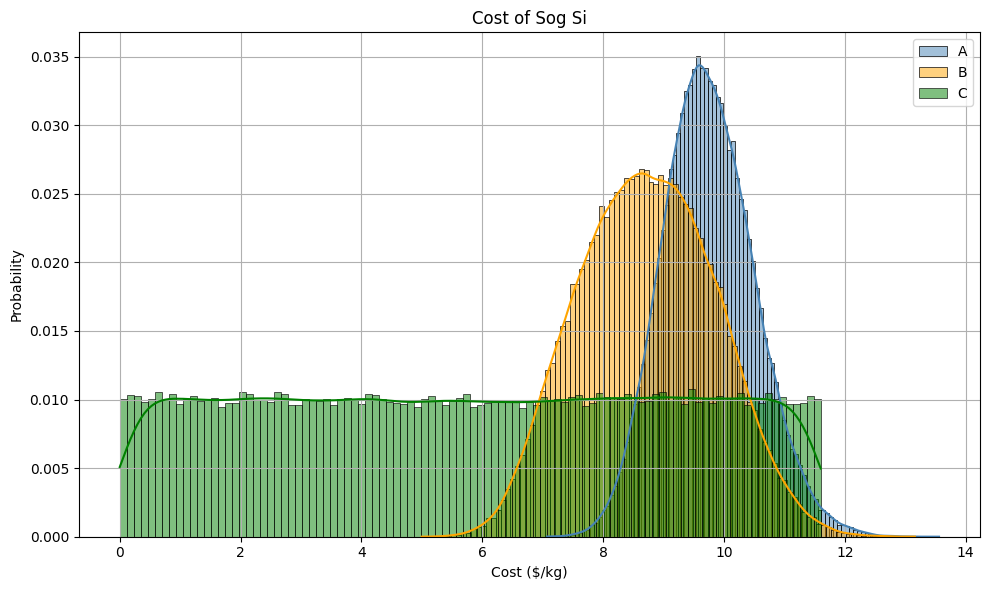

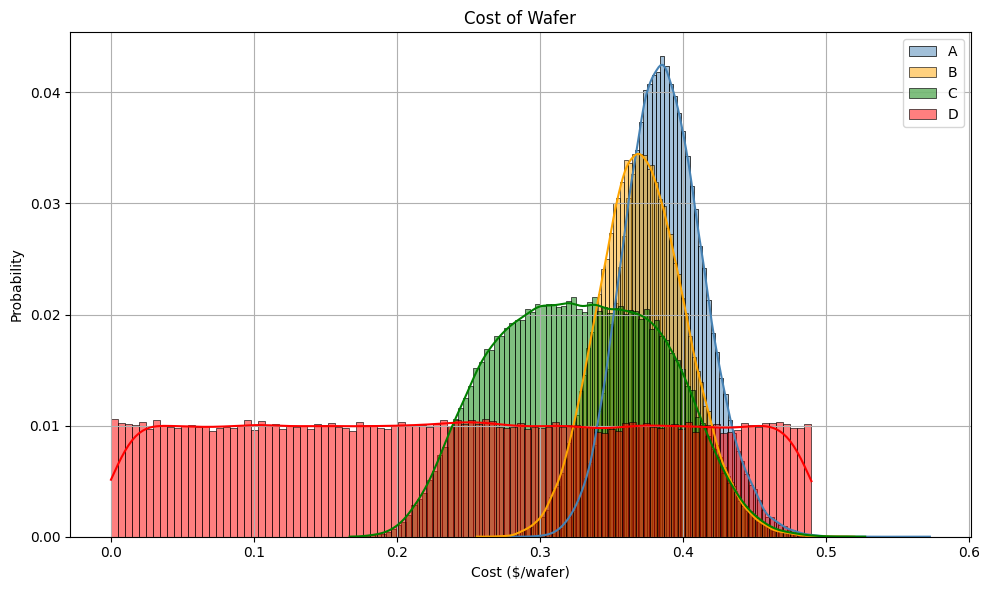

In [ ]:
production_type = 'SoG Si'
target_units = 'kg'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)

production_type = 'wafer'
target_units = 'wafer'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)


Plot Figure S2(a) and Figure S2(b)

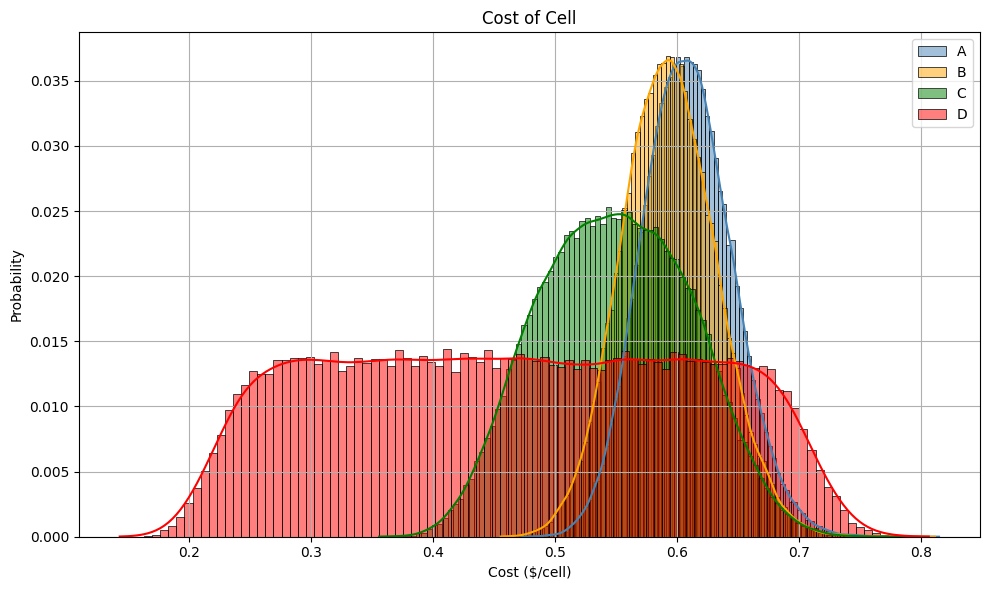

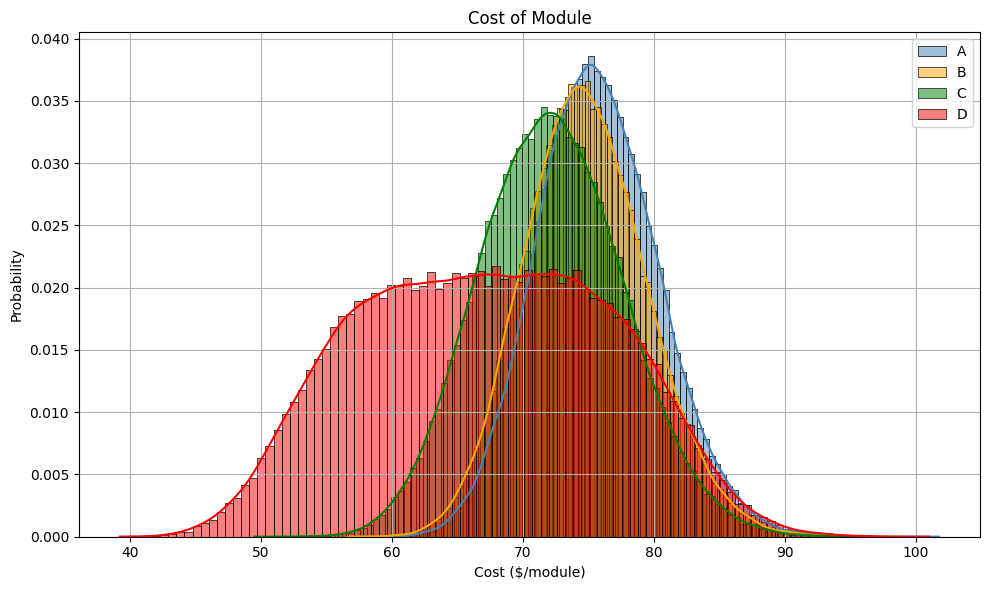

In [ ]:
production_type = 'cell'
target_units = 'cell'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)

production_type = 'module'
target_units = 'module'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)

Plot Figure 4

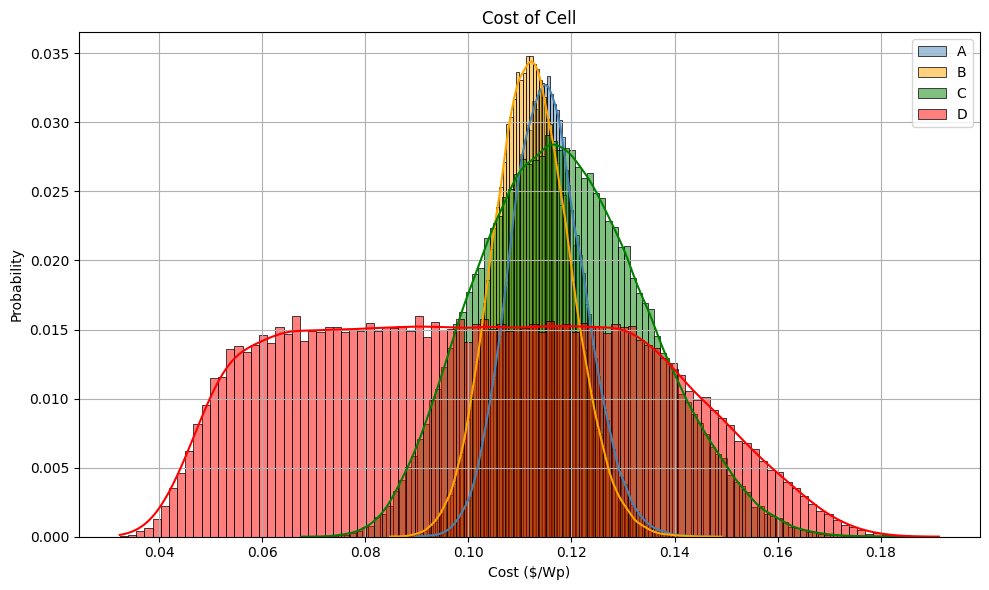

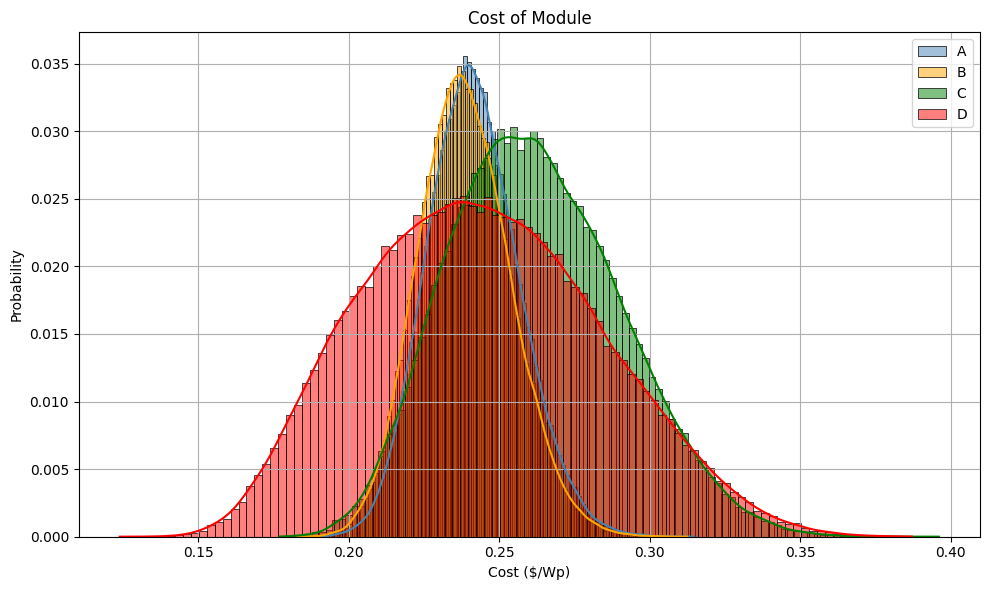

In [ ]:
production_type = 'cell'
target_units = 'Wp'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)

production_type = 'module'

cost_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)
plot_cost_distribution(cost_results, f'Cost of {production_type.title()}', target_units, colors)


Function for generating Figure 5

In [ ]:
def plot_relative_cost_difference(scenario, production_type, target_unit, cost_diff, df, efficiency_df, conversion_matrix):
  base_scenario = 'A'

  target_unit_base = 'Wp'
  base_production_type = 'module'

  filtered_df_base = filter_rows_by_production_type(df, base_production_type, base_scenario)
  filtered_df_base = convert_dataframe_units(filtered_df_base, target_unit_base, conversion_matrix)

  base_total_cost = filtered_df_base['Process Cost'].sum()
  base_efficiency = efficiency_df.loc[efficiency_df['Scenario'] == base_scenario, 'Median Efficiency'].values[0]

  # get the rest of the process costs beside the first one for the scenario
  filtered_df = filter_rows_by_production_type(df, base_production_type, scenario)
  filtered_df = convert_dataframe_units(filtered_df, target_unit, conversion_matrix)
  partial_costs = filtered_df['Process Cost'].iloc[1:].sum()

  # Extract the range
  filtered_df = filter_rows_by_production_type(df, production_type, scenario)
  filtered_df = convert_dataframe_units(filtered_df, target_unit, conversion_matrix)

  if cost_diff:
    base_filtered_df = filter_rows_by_production_type(df, production_type, base_scenario)
    base_filtered_df = convert_dataframe_units(base_filtered_df, target_unit, conversion_matrix)
    reference_cost = base_filtered_df['Process Cost'].sum()
  else:
    reference_cost = 0

  price_range_value = filtered_df['Process Cost Range'].values[0]
  # Extract the range
  efficiency_range_value = efficiency_df.loc[(efficiency_df['Scenario'] == scenario),'Efficiency Range'].values[0]

  num_points = 100
  x_grid = np.linspace(price_range_value[0], price_range_value[1], num_points) - reference_cost
  y_grid = np.linspace(efficiency_range_value[0], efficiency_range_value[1], num_points)-base_efficiency

  X, Y = np.meshgrid(x_grid, y_grid)
  # Z = ((X+partial_costs)* conversion_matrix.at['kg', 'Wp'] - base_total_cost)
  Z = ((X+reference_cost+partial_costs)* conversion_matrix.at[target_unit , target_unit_base]*base_efficiency/(Y+base_efficiency) - base_total_cost)

  plt.figure(figsize=(8, 6))
  norm = TwoSlopeNorm(vmin=Z.min(), vcenter=0, vmax=Z.max())
  contour = plt.contourf(X, Y, Z, levels=50, cmap='seismic', norm=norm)
  contour_lines = plt.contour(X, Y, Z, levels=5, colors='black', linewidths=0.8)
  plt.clabel(contour_lines, inline=True, fontsize=10, fmt="%.2f")

  plt.colorbar(contour, label='Z value')
  if cost_diff:
    plt.xlabel(f'Cost diff recovered vs virgin {production_type} Cost ($/{target_unit})')
  else:
    plt.xlabel(f'Recycled {production_type} Cost ($/{target_unit})')
  plt.ylabel('Cell Efficiency Differences (% abs)')
  plt.title(f'Relative Cost {scenario} vs {base_scenario} ($/W)')
  plt.grid(True)
  plt.tight_layout()
  plt.show()


Generate Figure 5

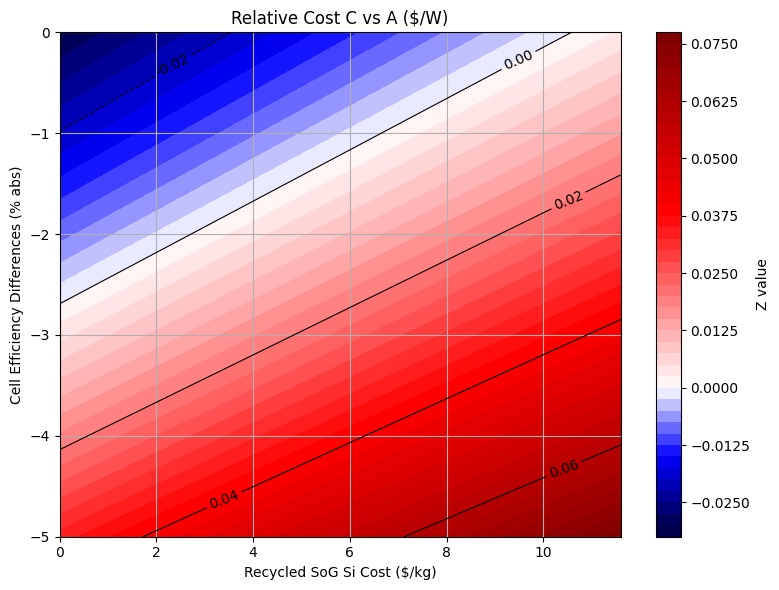

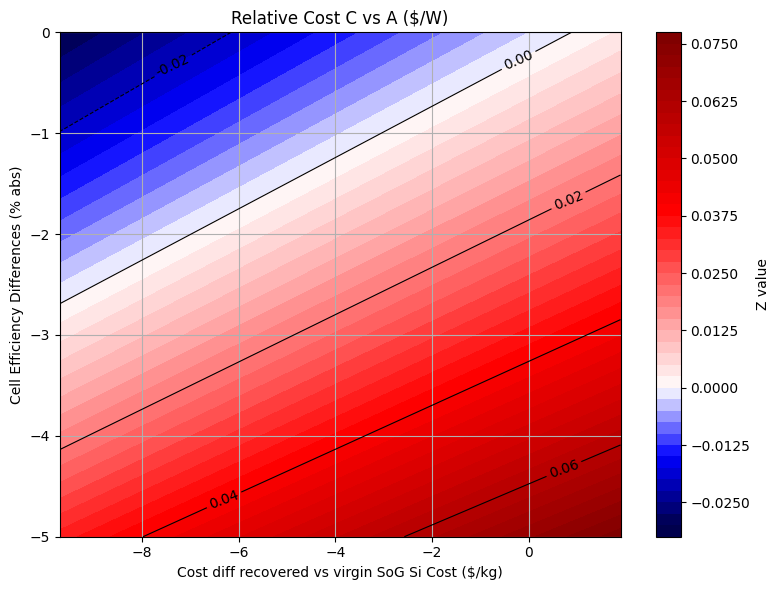

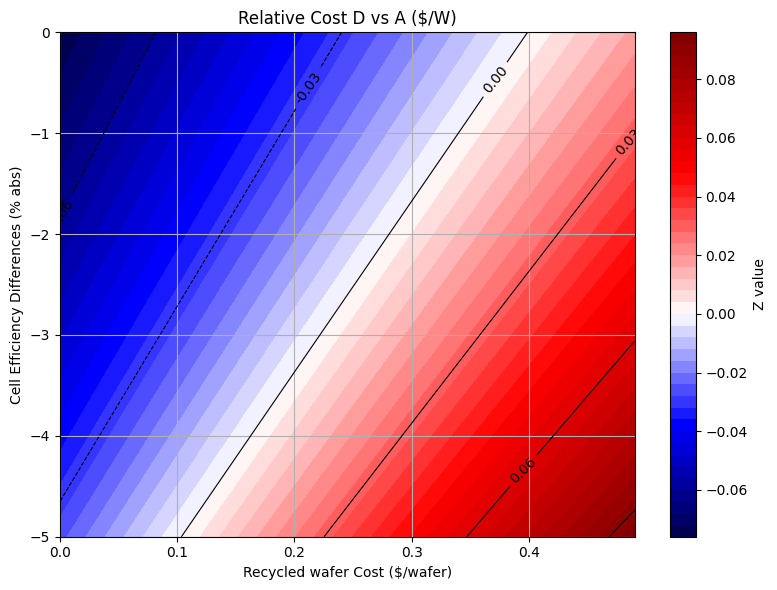

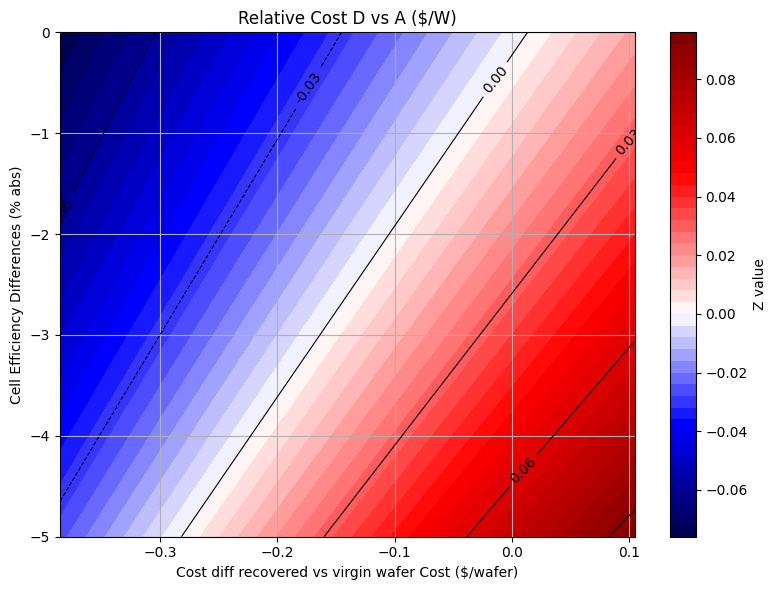

In [ ]:
scenario = 'C'
target_unit = 'kg'
production_type = 'SoG Si'
cost_diff = 0

plot_relative_cost_difference(scenario, production_type, target_unit, cost_diff, df, efficiency_df, conversion_matrix)

cost_diff = 1
plot_relative_cost_difference(scenario, production_type, target_unit, cost_diff, df, efficiency_df, conversion_matrix)

scenario = 'D'
target_unit = 'wafer'
production_type = 'wafer'

cost_diff = 0
plot_relative_cost_difference(scenario, production_type, target_unit, cost_diff, df, efficiency_df, conversion_matrix)

cost_diff = 1
plot_relative_cost_difference(scenario, production_type, target_unit, cost_diff, df, efficiency_df, conversion_matrix)





```
`# This is formatted as code`
```

Create the summary table containing the median, 10th and 90th percentile for figure 4

In [ ]:
# Summarize costs for both cell and module in Figure 4, formatted as "median (10th percentile–90th percentile)"
def summarize_costs(cell_results, module_results):
  summary = []
  for scenario in cell_results:
    cell_costs = cell_results[scenario]
    module_costs = module_results[scenario]

    cell_median = np.median(cell_costs)
    cell_p10 = np.percentile(cell_costs, 10)
    cell_p90 = np.percentile(cell_costs, 90)

    module_median = np.median(module_costs)
    module_p10 = np.percentile(module_costs, 10)
    module_p90 = np.percentile(module_costs, 90)

    summary.append({
      'Scenario': scenario,
      'Cell Cost ($/Wp)': f"{cell_median:.2f} ({cell_p10:.2f}-{cell_p90:.2f})",
      'Module Cost ($/Wp)': f"{module_median:.2f} ({module_p10:.2f}-{module_p90:.2f})"
    })

  return pd.DataFrame(summary)

# Recompute costs if not already stored
production_type = 'cell'
cell_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)

production_type = 'module'
module_results = generate_costs_by_scenario(df, production_type, target_units, conversion_matrix)

# Generate and display formatted summary
summary_df = summarize_costs(cell_results, module_results)
display(summary_df)

,Scenario,Cell Cost ($/Wp),Module Cost ($/Wp)
0,A,0.12 (0.11-0.12),0.24 (0.22-0.26)
1,B,0.11 (0.10-0.12),0.24 (0.22-0.26)
2,C,0.12 (0.10-0.14),0.26 (0.23-0.30)
3,D,0.10 (0.06-0.14),0.24 (0.19-0.30)
